**LABELS**<br>

Excerpts from the paper:<br>
> The HAM10000 Dataset: A Large Collection of Multi-Source Dermatoscopic Images of Common Pigmented Skin Lesions<br>
https://arxiv.org/abs/1803.10417



 **nv**<br>
 Melanocytic nevi are benign neoplasms of melanocytes and appear in a myriad of variants, which all are included in our series. The variants may differ significantly from a dermatoscopic point of view.<br>
 *[6705 images]*
 
 **mel**<br>
 Melanoma is a malignant neoplasm derived from melanocytes that may appear in different variants. If excised in an early stage it can be cured by simple surgical excision. Melanomas can be invasive or non-invasive (in situ). We included all variants of melanoma including melanoma in situ, but did exclude non-pigmented, subungual, ocular or mucosal melanoma.<br>*[1113 images]*
 
 
**bkl**<br>
 "Benign keratosis" is a generic class that includes seborrheic ker- atoses ("senile wart"), solar lentigo - which can be regarded a flat variant of seborrheic keratosis - and lichen-planus like keratoses (LPLK), which corresponds to a seborrheic keratosis or a solar lentigo with inflammation
and regression [22]. The three subgroups may look different dermatoscop- ically, but we grouped them together because they are similar biologically and often reported under the same generic term histopathologically. From a dermatoscopic view, lichen planus-like keratoses are especially challeng- ing because they can show morphologic features mimicking melanoma [23] and are often biopsied or excised for diagnostic reasons.<br>
*[1099 images]*

**bcc**<br>
Basal cell carcinoma is a common variant of epithelial skin cancer that rarely metastasizes but grows destructively if untreated. It appears in different morphologic variants (flat, nodular, pigmented, cystic, etc) [21], which are all included in this set.<br>
*[514 images]*
 
**akiec**<br>
Actinic Keratoses (Solar Keratoses) and intraepithelial Carcinoma (Bowen’s disease) are common non-invasive, variants of squamous cell car- cinoma that can be treated locally without surgery. Some authors regard them as precursors of squamous cell carcinomas and not as actual carci- nomas. There is, however, agreement that these lesions may progress to invasive squamous cell carcinoma - which is usually not pigmented. Both neoplasms commonly show surface scaling and commonly are devoid of pigment. Actinic keratoses are more common on the face and Bowen’s disease is more common on other body sites. Because both types are in- duced by UV-light the surrounding skin is usually typified by severe sun damaged except in cases of Bowen’s disease that are caused by human papilloma virus infection and not by UV. Pigmented variants exists for Bowen’s disease [19] and for actinic keratoses [20]. Both are included in this set.<br>*[327 images]*


**vasc**<br>
Vascular skin lesions in the dataset range from cherry angiomas to angiokeratomas [25] and pyogenic granulomas [26]. Hemorrhage is also included in this category.<br>
*[142 images]*

**df**<br>
Dermatofibroma is a benign skin lesion regarded as either a benign proliferation or an inflammatory reaction to minimal trauma. It is brown often showing a central zone of fibrosis dermatoscopically [24].<br>*[115 images]*


<br>*[Total images = 10015]*

In [1]:
# !pip3 install --upgrade pandas
# !pip3 install tensorflow-gpu==2.0.0b1
# !pip3 install -U --pre efficientnet
# !wget https://raw.githubusercontent.com/titu1994/keras_rectified_adam/master/tf_rectified_adam.py
# !pip3 install keras-rectified-adam

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1649309666016385120
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9962289987777198895
physical_device_desc: "device: XLA_CPU device"
]


In [27]:
from collections import Counter
import os
import shutil
import numpy as np
import pandas as pd
import cv2
import datetime
import itertools

from pathlib import Path
from PIL import Image
from tqdm import tqdm
from glob import glob

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.losses import CategoricalCrossentropy
from tf_rectified_adam import RectifiedAdam
from keras_radam.training import RAdamOptimizer
# from tensorflow.keras.applications.nasnet import NASNetLarge
# from tensorflow.keras.applications.nasnet import preprocess_input
from efficientnet.tfkeras import EfficientNetB7, EfficientNetB6

import tensorflow as tf

%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

print('Tensorflow: ',tf.version.VERSION)
print('Keras: ', tf.keras.__version__)
SEED = 2019
tf.random.set_seed(SEED)

Tensorflow:  2.0.0
Keras:  2.2.4-tf


### Dataset

The HAM10000 dataset consists of 10015 dermatoscopic images which can serve as a training set for academic machine learning purposes. Cases include a representative collection of all important diagnostic categories in the realm of pigmented lesions: Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec), basal cell carcinoma (bcc), benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl), dermatofibroma (df), melanoma (mel), melanocytic nevi (nv) and vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc).

More than 50% of lesions are confirmed through histopathology (histo), the ground truth for the rest of the cases is either follow-up examination (follow_up), expert consensus (consensus), or confirmation by in-vivo confocal microscopy (confocal). The dataset includes lesions with multiple images, which can be tracked by the lesion_id-column within the HAM10000_metadata file.

### Create stratified train, validation and test sets

We have 7 classes, 10015 images and 7470 cases. Some cases have several images. We would make stratified split preserving class structure. Also we would preserve structure regarding to image count per case.

In [4]:
#load metadata and rename label column
df = pd.read_csv('./input/HAM10000_metadata.csv')
df = df.rename(columns={"dx": "label"})
display(df.sort_values(by=['lesion_id']).head())
display(df['label'].value_counts())

,lesion_id,image_id,label,dx_type,age,sex,localization
9187,HAM_0000000,ISIC_0028498,nv,histo,60.0,male,back
9188,HAM_0000000,ISIC_0025346,nv,histo,60.0,male,back
726,HAM_0000001,ISIC_0027859,bkl,histo,70.0,female,face
1661,HAM_0000002,ISIC_0032622,mel,histo,65.0,female,lower extremity
1660,HAM_0000002,ISIC_0033848,mel,histo,65.0,female,lower extremity


nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: label, dtype: int64

In [5]:
#constructing columns to capture label's image-count structure
image_count = df.groupby("lesion_id").agg(image_count=pd.NamedAgg(column='image_id', aggfunc='count'),
                                         label=pd.NamedAgg(column='label', aggfunc='last')).reset_index()
image_count['labels_with_count'] = image_count['label'] + image_count['image_count'].astype(str)
display(pd.DataFrame(image_count.groupby('labels_with_count').count()['image_count']))

,image_count
labels_with_count,
akiec1,151
akiec2,57
akiec3,18
akiec4,2
bcc1,175
bcc2,118
bcc3,33
bcc4,1
bkl1,440


We're goin to split for train,validation,test subsets as 80%, 10%, 10%. Therefore a group should have minimum 10 images to be splittable.  We have to merge groups with image count below 10

In [6]:
image_count.loc[image_count['labels_with_count'] == 'akiec4', 'labels_with_count'] = 'akiec3'
image_count.loc[image_count['labels_with_count'] == 'bcc4', 'labels_with_count'] = 'bcc3'
image_count.loc[image_count['labels_with_count'] == 'bkl5', 'labels_with_count'] = 'bkl4'
image_count.loc[image_count['labels_with_count'] == 'bkl6', 'labels_with_count'] = 'bkl4'
image_count.loc[image_count['labels_with_count'] == 'mel4', 'labels_with_count'] = 'mel3'
image_count.loc[image_count['labels_with_count'] == 'mel5', 'labels_with_count'] = 'mel3'
image_count.loc[image_count['labels_with_count'] == 'mel6', 'labels_with_count'] = 'mel3'
image_count.loc[image_count['labels_with_count'] == 'nv5', 'labels_with_count'] = 'nv4'
image_count.loc[image_count['labels_with_count'] == 'nv6', 'labels_with_count'] = 'nv4'
image_count.loc[image_count['labels_with_count'] == 'vasc4', 'labels_with_count'] = 'vasc3'

display(pd.DataFrame(image_count.groupby('labels_with_count').count()['image_count']))

,image_count
labels_with_count,
akiec1,151
akiec2,57
akiec3,20
bcc1,175
bcc2,118
bcc3,34
bkl1,440
bkl2,220
bkl3,55


Now we can actually do the split for for train, validation and test sets. Note, that we are splitting the cases, not the images as if done otherwise there might be a data leakage.


In [7]:
train_set, validation_and_test_set = train_test_split(image_count, test_size=0.2, random_state=SEED, stratify=image_count['labels_with_count'])
validation_set, test_set = train_test_split(validation_and_test_set, test_size=0.5, random_state=SEED, stratify=validation_and_test_set['labels_with_count'])

train_set = train_set.assign(subset='train')
validation_set = validation_set.assign(subset='validation')
test_set = test_set.assign(subset='test')

for subset in [train_set, validation_set, test_set]:
    print(subset['subset'].iloc[0], subset.shape[0], sep=': ')
    
dataset = pd.concat([train_set, validation_set, test_set])
df = pd.merge(df, dataset[['lesion_id','subset']], on='lesion_id')
df

train: 5976
validation: 747
test: 747


,lesion_id,image_id,label,dx_type,age,sex,localization,subset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,test
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,test
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,train
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,train
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,train
...,...,...,...,...,...,...,...,...
10010,HAM_0005579,ISIC_0028393,akiec,histo,80.0,male,face,train
10011,HAM_0001576,ISIC_0033705,akiec,histo,60.0,male,face,train
10012,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,train
10013,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,train


Data is highly unbalanced as can be seen in class distribution of train set. There are diffrent ways to deal with imblanced data. One way is to oversample the data. We used oversampling to balance the data appling random augmentations( flips, brighness, saturation) and random crop to images. But that approach doesn't give any significant increase is validation metrics. The second approach is to use class weights for loss function and metrics calculations. We used the second one as our final approach.

In [8]:
df.loc[df['subset'] == 'train',['image_id','label']].groupby("label").agg(count=pd.NamedAgg(column='image_id', aggfunc='count'))

,count
label,
akiec,262
bcc,410
bkl,882
df,91
mel,889
nv,5366
vasc,113


### Manage files structure

In order to use Keras's ImageGenerator and flow method, we need to create directories structure with top level dirs as train, validation, test and sub-directories with labels names.

In [9]:
PATH = "./dataset_small/"
SIZE = 450 # we are setting input size to 450 as the images has 600 × 450 size.
CREATE_STRUCTURE = False if os.path.exists(PATH) else True
TRAIN_DATA_DIR = os.path.join(PATH,'train')
VALIDATION_DATA_DIR = os.path.join(PATH,'validation')
TEST_DATA_DIR = os.path.join(PATH,'test')

#get labels
labels = df.groupby('label').last().index.tolist()
labels

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

Testing random croping, central croping and different augmentations we come to conclusion, that only cetnral crop makes sense in terms of model metrics improvment.
One of the limitations of using Keras's ImageDataGenerator is that preprocess function(even custom one) is applied only after resizing. Therefore we cannot make central crop as preprocess function. Instead we would make central crop while sorting dataset.

In [10]:
def central_crop(image):
    crop_1 = int((600-SIZE)/2)
    crop_2 = int((450-SIZE)/2)
    if image.shape[0]==600:
        return image[crop_1:-crop_1,crop_2:450 if crop_2==0 else -crop_2,:]
    else:
        return image[crop_2:450 if crop_2==0 else -crop_2,crop_1:-crop_1,:]

In [11]:
#creating dir structure
if CREATE_STRUCTURE:
    def mkdir(path):
        if not os.path.exists(path):
            os.mkdir(path)
    mkdir(PATH)
    for DIR in [TRAIN_DATA_DIR,VALIDATION_DATA_DIR,TEST_DATA_DIR]:
        mkdir(DIR)
        for label in labels:
            mkdir(os.path.join(DIR,label))

    #move all images to ./dataset directory
    for sub_dir in ['HAM10000_images_part_1','HAM10000_images_part_2']:
        for image in os.listdir(os.path.join('input',sub_dir)):
            source = os.path.join('input',sub_dir,image)
            destination = os.path.join(PATH,image)
            if PATH=='./dataset/':
                shutil.copy(source,destination)
            else:
                img = tf.io.read_file(source)
                img = tf.io.decode_jpeg(img, dct_method='INTEGER_ACCURATE')
                img = central_crop(img)
                img = tf.io.encode_jpeg(img, quality=100, chroma_downsampling=False)
                tf.io.write_file(destination, img)
                
    #move images to corresponding directories
    for index, image in df.iterrows():
        source = os.path.join(PATH,image['image_id']) + '.jpg'
        destination = os.path.join(PATH,image['subset'], image['label'])
        shutil.move(source,destination)


### Preprocess functions ###

Here we want to setup Keras ImageDataGenerators for the model training. Also we would like to subtract the per-channel training set mean from the images. To implement this, we need to provide that mean for ImageDataGenerator. To do so we need to manually load all train subset and calculate the mean. We need to do this operation only once as later we can just use the mean vector. 

The one thing to notice is that ImageDataGenerator's standardize method first applies preprocessing_function and after subtract mean. Therefore we need to calculate mean on the dataset preprocessed with the same preprocessing_function as used in ImageDataGenerator.

In [12]:
def shade_of_grey(img):
    """
    Implementation for shade of grey algorithm as proposed in:
    Graham D. Finlayson and Elisabetta Trezzi
    "Shades of Gray and Colour Constancy", 2004
    Estimates the light source of an input_image and corrects image 
    colors by performing diagonal transformation according to 
    given estimated illumination of the image.
    :param img: rgb input image (NxMx3)
    :return: corrected image
    """
    
    deriv_image = img.copy()
    
    # remove saturated pixels in input image
    deriv_image[deriv_image >= 255] = 0
    # estimate illuminations
    mink_norm = 6 #Minkowski norm, can adjusted as parametr.
    illum = ((deriv_image.astype(np.uint64) ** mink_norm).sum(axis=(0,1))) ** (1/mink_norm)
    # normalize estimated illumination
    som = np.linalg.norm(illum)
    illum /= som
    correcting_illum = illum * np.sqrt(3) 
    #correct image
    img = img.astype(float) / (illum * np.sqrt(3))
    
    return np.around(img).astype(np.uint16)

In [13]:
def custom_preprocess(image):
#     mean =  [0.75708639, 0.56659932, 0.59902178] # balanced dataset
#     std =  [0.13877631, 0.15493133, 0.16716208] # balanced dataset
#     mean =  [0.76413945, 0.53801809, 0.56173534] #no shade of gray
#     std =  [0.13831915, 0.15890724, 0.17760346] #no shade of gray
    mean =  [0.70010796, 0.59071487, 0.58644372] #shade of gray
    std =  [0.17023377, 0.16380622, 0.17671748] #shade of gray
    
    image = shade_of_grey(image).astype(np.float32)
    image = image.astype(np.float32)
    image /= 255.
    image -= mean
    image /= std
    

    return image


### Generators setup ###

In [19]:
BATCH_SIZE = 64 # batch size depends on your GPU's RAM memory, generally set as large as you can
preprocess = custom_preprocess

train_generator = ImageDataGenerator(horizontal_flip=True,
                                     vertical_flip=True,
                                     preprocessing_function=preprocess)\
                  .flow_from_directory(
                  TRAIN_DATA_DIR,
                  target_size=(SIZE, SIZE), 
                  batch_size=BATCH_SIZE, 
                  class_mode='categorical',seed=SEED,shuffle=True)


validation_generator = ImageDataGenerator(preprocessing_function=preprocess)\
                       .flow_from_directory(
                        VALIDATION_DATA_DIR,
                        shuffle=False, 
                        target_size=(SIZE, SIZE),
                        batch_size=BATCH_SIZE, 
                        class_mode='categorical',
                        seed=SEED)



test_generator = ImageDataGenerator(preprocessing_function=preprocess)\
                 .flow_from_directory(
                 TEST_DATA_DIR,
                 shuffle=False, 
                 target_size=(SIZE, SIZE),
                 batch_size=BATCH_SIZE, 
                 class_mode='categorical',
                 seed=SEED)

Found 8013 images belonging to 7 classes.
Found 1000 images belonging to 7 classes.
Found 1002 images belonging to 7 classes.


In [15]:
#get class weights
train_generator = ImageDataGenerator().flow_from_directory(TRAIN_DATA_DIR)

counter = Counter(train_generator.classes)
max_val = max(Counter(train_generator.classes).values())
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}
weights_labeled = { key:class_weights[value] for key,value in train_generator.class_indices.items()}

largest_class = { 'index':  {v: k for k, v in class_weights.items()}[1.0] }
largest_class['value'] = counter[largest_class['index']]
largest_class['name'] = {v: k for k, v in train_generator.class_indices.items()}[largest_class['index']]

print('# of images in each class: ', counter)
print('class_weights: ', class_weights)
print('class_weights labeled: ',weights_labeled)
print('largest_class: ',largest_class)

Found 8013 images belonging to 7 classes.
# of images in each class:  Counter({5: 5366, 4: 889, 2: 882, 1: 410, 0: 262, 6: 113, 3: 91})
class_weights:  {0: 20.480916030534353, 1: 13.08780487804878, 2: 6.083900226757369, 3: 58.967032967032964, 4: 6.0359955005624295, 5: 1.0, 6: 47.48672566371681}
class_weights labeled:  {'akiec': 20.480916030534353, 'bcc': 13.08780487804878, 'bkl': 6.083900226757369, 'df': 58.967032967032964, 'mel': 6.0359955005624295, 'nv': 1.0, 'vasc': 47.48672566371681}
largest_class:  {'index': 5, 'value': 5366, 'name': 'nv'}


### Load and compile the model

In [ ]:
tf.keras.backend.clear_session()
session_dir = './EFnet6/'

base_model =  EfficientNetB6(weights='imagenet', include_top=False, pooling='avg', input_shape=(SIZE, SIZE, 3))
x = base_model.output
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

W1020 14:10:37.107673 4632839616 nn_ops.py:4283] Large dropout rate: 0.5125 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W1020 14:10:37.574469 4632839616 nn_ops.py:4283] Large dropout rate: 0.5375 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W1020 14:10:37.749101 4632839616 nn_ops.py:4283] Large dropout rate: 0.55 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


In [16]:
# # load checkpoins
# session_dir = './'
# filename = 'fine-tune-0.9426-0.9876-01-.hdf5'
# model = tf.keras.models.load_model(session_dir + filename, custom_objects={'RectifiedAdam': RectifiedAdam})

W1020 14:11:45.087090 4614792640 nn_ops.py:4283] Large dropout rate: 0.5125 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W1020 14:11:45.351089 4614792640 nn_ops.py:4283] Large dropout rate: 0.5375 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W1020 14:11:45.811285 4614792640 nn_ops.py:4283] Large dropout rate: 0.55 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Firstly we're going to train only the last layer. After that is done we want to train all other layers, but there is a limitation due GPU's memory capacity. For that reason we find sutable batch_size and split layers in 4 parts. That will allow us to train each part of the layers independently. 

In [ ]:
# freezing all layers except last
for layer in model.layers[-1:]:
    layer.trainable=True

In [ ]:
# # freezing layers by parts

# freeze_window = len(model.layers) // 4

# for layer in model.layers:
#     layer.trainable=False
# for layer in model.layers[3*freeze_window:4*freeze_window]:
#     layer.trainable=True
# for layer in model.layers[-1:]:
#     layer.trainable=True
    
# for i, layer in enumerate(model.layers):
#     if layer.trainable==True:
#         print (i,'T',model.layers[i])

Since classes are highly imbalanced, we would like to use such metrics as auc and account for weights of each class while calculating such metrics.

In [17]:
#setting metrics

precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
cat_acc = tf.keras.metrics.CategoricalAccuracy()
auc = tf.keras.metrics.AUC()

radam = RectifiedAdam(learning_rate=0.005) #for feature extraction we would use higher learning rate, for fine-tuning much lower.

model.compile(optimizer=radam, loss='categorical_crossentropy', weighted_metrics=[auc, recall, precision, cat_acc])

print(model.metrics_names)

['loss', 'auc', 'recall', 'precision', 'categorical_accuracy']


In [24]:
#setting callbacks
filepath="top-tune-{val_auc:.4f}-{auc:.4f}-{epoch:02d}-.hdf5"
checkpoint = ModelCheckpoint(session_dir + filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

callbacks_list = [checkpoint, tensorboard_callback]

### Train ###

In [ ]:
history = model.fit_generator(generator=train_generator,
                                  steps_per_epoch=np.ceil(train_generator.n / BATCH_SIZE),
                                  epochs=4, 
                                  workers=os.cpu_count(),
                                  class_weight=class_weights,
                                  validation_data=validation_generator, 
                                  validation_steps=np.ceil(validation_generator.n / BATCH_SIZE),
                                  callbacks=callbacks_list,
                                  verbose=1) 

### Plots ###

In [30]:
def plot_metrics(history):

    import matplotlib as mpl
    mpl.rcParams['figure.figsize'] = (12, 10)
    metrics =  model.metrics_names
    metrics = ['auc','loss', 'recall', 'categorical_accuracy', 'precision', ]
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(3,2,n+1)
        if isinstance(history,list):
            epochs = list(range(len(history) * len(history[0].epoch)))
            train_metrics = sum([[value for value in hist.history[metric]] for hist in history],[])
            val_metrics = sum([[value for value in hist.history['val_'+metric]] for hist in history],[])
            plt.plot(epochs,  train_metrics, color=colors[0], label='Train')
            plt.plot(epochs, val_metrics,
                 color=colors[1], label='Val')
        else:
            plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
            plt.plot(history.epoch, history.history['val_'+metric],
                     color=colors[1], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
#         elif metric == 'auc':
#             plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()


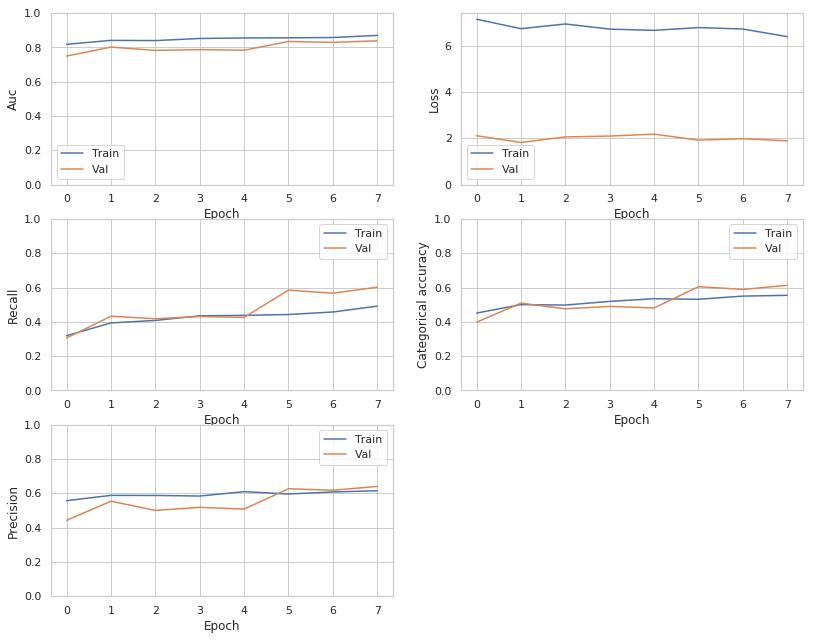

In [31]:
#top-tune-augs with rms_prop
plot_metrics(history)

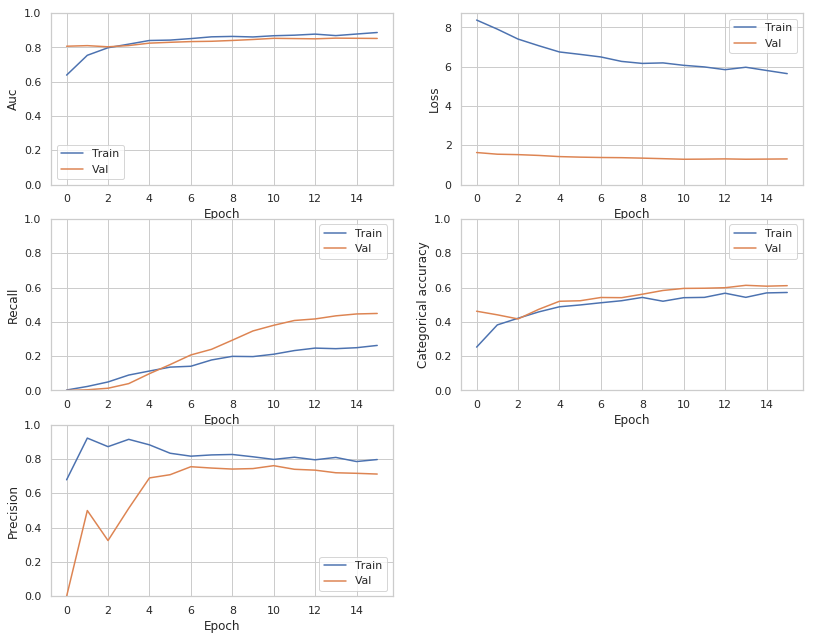

In [39]:
#top-tune-no-augs with radam
plot_metrics(history)

In [20]:
output = model.evaluate_generator(generator = test_generator, steps=np.ceil(test_generator.n / BATCH_SIZE), verbose=1)
output

16/16 [==============================] - 552s 35s/step - loss: 0.8660 - auc: 0.9477 - recall: 0.7495 - precision: 0.7799 - categorical_accuracy: 0.7595


[0.8660486347507685, 0.9476527, 0.749501, 0.7798546, 0.759481]

### Confusion Matrix

In [22]:
# Get the labels of the test images.

test_labels = test_generator.classes
test_labels

array([0, 0, 0, ..., 6, 6, 6], dtype=int32)

In [ ]:
# We need these to plot the confusion matrix.


In [24]:
# Print the label associated with each class
test_generator.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

In [21]:
# make a prediction
predictions = model.predict_generator(generator = test_generator, steps=np.ceil(test_generator.n / BATCH_SIZE), verbose=1)
predictions.shape

16/16 [==============================] - 947s 59s/step


(1002, 7)

In [25]:
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()




In [ ]:
test_labels.shape

In [ ]:
# argmax returns the index of the max value in a row


In [ ]:
test_batches.class_indices

Confusion matrix, without normalization
[[  9   0   5   0   3  17   0]
 [  1  10   2   1   3  36   0]
 [  0   0  29   0   9  69   0]
 [  0   0   0   4   1   5   1]
 [  1   0   2   4  45  60   0]
 [  1   0   3   2  10 654   1]
 [  0   0   0   0   1   3  10]]


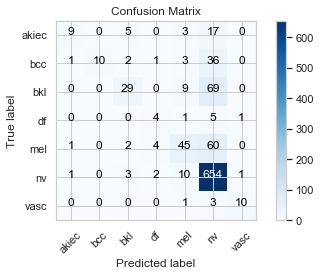

In [28]:
# Define the labels of the class indices. These need to match the 
# order shown above.
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

### Generate the Classification Report

In [29]:
# Get the index of the class with the highest probability score
y_pred = np.argmax(predictions, axis=1)

# Get the labels of the test images.
y_true = test_generator.classes

In [30]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

              precision    recall  f1-score   support

       akiec       0.75      0.26      0.39        34
         bcc       1.00      0.19      0.32        53
         bkl       0.71      0.27      0.39       107
          df       0.36      0.36      0.36        11
         mel       0.62      0.40      0.49       112
          nv       0.77      0.97      0.86       671
        vasc       0.83      0.71      0.77        14

   micro avg       0.76      0.76      0.76      1002
   macro avg       0.72      0.45      0.51      1002
weighted avg       0.76      0.76      0.72      1002



**Precision** = Given a class prediction from a classifier, how likely is it to be correct?<br>
**Recall** = Given a class, will the classifier be able to detect it?<br>
**F1 Score** = The harmonic mean of the recall and precision. Essentially, it punishes extreme values.

### Convert model to TF Lite

In [39]:
filename = 'fine-tune-0.9426-0.9876-01-.hdf5'

# model = tf.keras.models.load_model(filename, custom_objects={'RectifiedAdam': RectifiedAdam})
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("skin_inspector.tflite", "wb").write(tflite_model)

162732664

### Tensorflow 2.0

Here we make simple experiment - load the image, decode it, encode it, save and load again. How many pixels would have the same value? We find out, that tf module has much more accuracy in this operation, so we used tf for image operations in this research.

In [176]:
images_paths = np.array(glob(os.path.join(TEST_DATA_DIR, '*', '*.jpg')))
imag = tf.io.decode_jpeg(tf.io.read_file(images_paths[2]), dct_method='INTEGER_ACCURATE')
img = tf.io.encode_jpeg(imag, quality=100, chroma_downsampling=False)
tf.io.write_file('./aaa.jpg', img)
imag2 = tf.io.decode_jpeg(tf.io.read_file('./aaa.jpg'), dct_method='INTEGER_ACCURATE')
comp = (imag == imag2).numpy()
display(np.sum(comp)/comp.size)
np.sum(comp)

0.9259572016460905

562519

In [177]:
images_paths = np.array(glob(os.path.join(TEST_DATA_DIR, '*', '*.jpg')))
imag = cv2.imread(images_paths[0])
cv2.imwrite('./aaa.jpg', imag, [int(cv2.IMWRITE_JPEG_QUALITY), 100])
imag2 = cv2.imread('./aaa.jpg')
comp = (imag == imag2)
display(np.sum(comp)/comp.size)
np.sum(comp)

0.48036378600823043

291821

There are different ways to compute mean of the entire dataset. One limitation is the RAM memory. To be able to compute mean for the balanced train dataset (35000 images) we had to have 150 GB free memory. And that amount was not enough for computing std for the entire dataset. Therefore we developed a function for processing images one by one. We compared two implementations with tf module and numpy module. As can be seen tf module 1.5 times faster than numpy anologue.

In [225]:
def compute_statistics(subset_dir):
    images_paths = np.array(glob(os.path.join(subset_dir, '*', '*.jpg')))
    dataset_mean = []
    dataset_std = []
    
    def get_stat(stack_array, std=False):
        for images_path in tqdm(images_paths):
            img = read_image(images_path)
            img = shade_of_grey(img.numpy())
            img = tf.convert_to_tensor(img,tf.dtypes.float64)
            if std:
                img = (img - dataset_mean) ** 2
            img = tf.math.reduce_mean(img, axis=[-2,-3])
            stack_array.append(img)
        return tf.math.reduce_mean(tf.stack(stack_array), axis=0) 
    dataset_mean = get_stat(dataset_mean)
    dataset_std = get_stat(dataset_std,std=True) ** (1/2)

    print('mean = ', dataset_mean.numpy() / 255)
    print('std = ', dataset_std.numpy() / 255)

In [226]:
if CREATE_STRUCTURE:
    compute_statistics(TRAIN_DATA_DIR)

100%|██████████| 8013/8013 [02:17<00:00, 58.09it/s]

mean =  [0.70010796 0.59071487 0.58644372]
std =  [0.17023377 0.16380622 0.17671748]


Numpy

In [227]:
def compute_statistics(subset_dir):
    images_paths = np.array(glob(os.path.join(subset_dir, '*', '*.jpg')))
    dataset_mean = []
    dataset_std = []
    
    def get_stat(stack_array, std=False):
        for images_path in tqdm(images_paths):
            img = read_image(images_path).numpy().astype(np.float32)
            img = shade_of_grey(img)
            if std:
                img = (img - dataset_mean) ** 2
            img = img.mean(axis=(0,1))
            stack_array.append(img)
        return np.stack(stack_array).mean(axis=0) 
    dataset_mean = get_stat(dataset_mean)
    dataset_std = get_stat(dataset_std,std=True) ** (1/2)
    
    print('mean = ', dataset_mean / 255.)
    print('std = ', dataset_std / 255.)

In [228]:
if CREATE_STRUCTURE:
    compute_statistics(TRAIN_DATA_DIR)

100%|██████████| 8013/8013 [03:24<00:00, 39.09it/s]


mean =  [0.70010796 0.59071487 0.58644372]
std =  [0.17023377 0.16380622 0.17671748]


Also we tried to use custom loss and custom metrics

In [21]:
class WeightedCategoricalCrossentropy(CategoricalCrossentropy):
    
    def __init__(self, cost_mat, name='weighted_categorical_crossentropy', **kwargs):
        assert(cost_mat.ndim == 2)
        assert(cost_mat.shape[0] == cost_mat.shape[1])
        
        super().__init__(name=name, **kwargs)
        self.cost_mat = K.cast_to_floatx(cost_mat)
    
    def __call__(self, y_true, y_pred):
      
        return super().__call__(
            y_true=y_true,
            y_pred=y_pred,
            sample_weight=get_sample_weights(y_true, y_pred, self.cost_mat),
        )


def get_sample_weights(y_true, y_pred, cost_m):
    num_classes = len(cost_m)

    y_pred.shape.assert_has_rank(2)
    y_pred.shape[1].assert_is_compatible_with(num_classes)
    y_pred.shape.assert_is_compatible_with(y_true.shape)

    y_pred = K.one_hot(K.argmax(y_pred), num_classes)

    y_true_nk1 = K.expand_dims(y_true, 2)
    y_pred_n1k = K.expand_dims(y_pred, 1)
    cost_m_1kk = K.expand_dims(cost_m, 0)

    sample_weights_nkk = cost_m_1kk * y_true_nk1 * y_pred_n1k
    sample_weights_n = K.sum(sample_weights_nkk, axis=[1, 2])

    return sample_weights_n

In [22]:
class WeightedCategoricalAccuracy(tf.keras.metrics.CategoricalAccuracy):

    def __init__(self, cost_mat, name='weighted_categorical_accuracy', **kwargs):
        assert(cost_mat.ndim == 2)
        assert(cost_mat.shape[0] == cost_mat.shape[1])
        
        super().__init__(name=name, **kwargs)
        self.cost_mat = K.cast_to_floatx(cost_mat)
    
    def update_state(self, y_true, y_pred, sample_weight=None):
    
        return super().update_state(
            y_true=y_true,
            y_pred=y_pred,
            sample_weight=get_sample_weights(y_true, y_pred, self.cost_mat),
        )